In [6]:
import pickle
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys
import os

In [7]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [9]:
from outlier import Outlier 
from Visualizer import *
from selector import *

In [10]:
db = pd.read_csv("../data/clean_data.csv")
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 57 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        150001 non-null  int64  
 1   Unnamed: 0.1                      150001 non-null  int64  
 2   Bearer Id                         149010 non-null  float64
 3   Start                             150000 non-null  object 
 4   Start ms                          150000 non-null  float64
 5   End                               150000 non-null  object 
 6   End ms                            150000 non-null  float64
 7   Dur. (ms)                         150000 non-null  float64
 8   IMSI                              149431 non-null  float64
 9   MSISDN/Number                     148935 non-null  float64
 10  IMEI                              149429 non-null  float64
 11  Last Location Name                148848 non-null  o

In [18]:
#display the aggregate of user over view analysis
univariate_analysis = db.groupby('MSISDN/Number').agg({'Dur. (ms)':'sum', 'Total Data Volume (Bytes)':'sum', 'Bearer Id':'count'}).reset_index()
univariate_analysis['no.xdr_session'] = univariate_analysis['Bearer Id'] 
univariate_analysis.describe()

,MSISDN/Number,Dur. (ms),Total Data Volume (Bytes),Bearer Id,no.xdr_session
count,8.970100e+04,8.970100e+04,8.970100e+04,89701.000000,89701.000000
mean,3.365752e+10,1.657319e+05,8.231061e+08,1.655567,1.655567
std,2.286132e+07,7.898208e+06,3.839876e+10,77.691619,77.691619
min,3.360300e+10,7.146000e+03,3.324901e+07,0.000000,0.000000
25%,3.365003e+10,7.020100e+04,3.585908e+08,1.000000,1.000000
50%,3.366175e+10,1.020870e+05,6.183475e+08,1.000000,1.000000
75%,3.366805e+10,1.727990e+05,8.569635e+08,2.000000,2.000000
max,3.373178e+10,2.364117e+09,1.149296e+13,23255.000000,23255.000000


In [20]:
univariate_analysis.nlargest(10, 'no.xdr_session')

,MSISDN/Number,Dur. (ms),Total Data Volume (Bytes),Bearer Id,no.xdr_session
89700,3.373178e+10,2.364117e+09,1.149296e+13,23255,23255
0,3.360300e+10,7.613873e+07,4.095721e+11,805,805
12925,3.362632e+10,4.004641e+06,7.971167e+09,18,18
5836,3.361489e+10,3.897619e+06,8.846226e+09,17,17
12579,3.362578e+10,4.135306e+06,8.499621e+09,17,17
36451,3.365973e+10,3.490637e+06,7.705863e+09,16,16
75762,3.367588e+10,3.330290e+06,7.891111e+09,15,15
64517,3.366716e+10,3.111894e+06,5.618394e+09,13,13
65,3.360313e+10,2.853411e+06,4.976195e+09,12,12
678,3.360452e+10,2.778192e+06,5.487855e+09,12,12


In [21]:
univariate_analysis.nlargest(10, 'Dur. (ms)')

,MSISDN/Number,Dur. (ms),Total Data Volume (Bytes),Bearer Id,no.xdr_session
89700,3.373178e+10,2.364117e+09,1.149296e+13,23255,23255
0,3.360300e+10,7.613873e+07,4.095721e+11,805,805
12579,3.362578e+10,4.135306e+06,8.499621e+09,17,17
12925,3.362632e+10,4.004641e+06,7.971167e+09,18,18
5836,3.361489e+10,3.897619e+06,8.846226e+09,17,17
36451,3.365973e+10,3.490637e+06,7.705863e+09,16,16
75762,3.367588e+10,3.330290e+06,7.891111e+09,15,15
64517,3.366716e+10,3.111894e+06,5.618394e+09,13,13
65,3.360313e+10,2.853411e+06,4.976195e+09,12,12
13393,3.362708e+10,2.780499e+06,5.754731e+09,12,12


In [22]:
univariate_analysis.nlargest(10, 'Total Data Volume (Bytes)')

,MSISDN/Number,Dur. (ms),Total Data Volume (Bytes),Bearer Id,no.xdr_session
89700,3.373178e+10,2.364117e+09,1.149296e+13,23255,23255
0,3.360300e+10,7.613873e+07,4.095721e+11,805,805
5836,3.361489e+10,3.897619e+06,8.846226e+09,17,17
12579,3.362578e+10,4.135306e+06,8.499621e+09,17,17
12925,3.362632e+10,4.004641e+06,7.971167e+09,18,18
75762,3.367588e+10,3.330290e+06,7.891111e+09,15,15
36451,3.365973e+10,3.490637e+06,7.705863e+09,16,16
62427,3.366646e+10,2.595346e+06,7.308501e+09,11,11
56640,3.366471e+10,2.602215e+06,6.872347e+09,11,11
85854,3.369879e+10,2.637462e+06,6.540899e+09,11,11


### Outliers

In [24]:
Outlier = Outlier(univariate_analysis)

<AxesSubplot:>

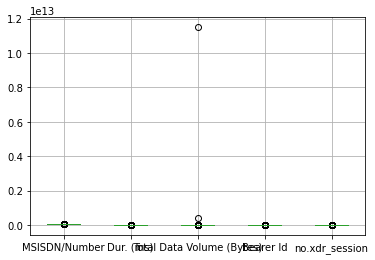

In [25]:
univariate_analysis.boxplot()

In [29]:
Outlier.getOverview(['no.xdr_session', 'Dur. (ms)', 'Total Data Volume (Bytes)'])

Name of columns,Dur. (ms),Total Data Volume (Bytes),no.xdr_session
Min,7146,3.3249e+07,0
Q1,70201,3.58591e+08,1
Median,102087,6.18347e+08,1
Q3,172799,8.56963e+08,2
Max,2.36412e+09,1.1493e+13,23255
IQR,102598,4.98373e+08,1
Lower fence,-83696,-3.88968e+08,-0.5
Upper fence,326696,1.60452e+09,3.5
Skew,298.925,298.874,298.93
Number_of_outliers,5692,4403,2681


In [ ]:
Outlier.replace_outliers_with_fences(['no.xdr_session', 'Dur (ms)', 'Total Data Volume (Bytes)'])